# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add PRA folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/PRA")

Wall time: 0 ns


# Overview

In the following notebok we evaluate the Polar Rotation Angle (PRA) on a two-dimensional, satellite-altimetry-derived ocean-surface current product (AVISO). The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data'.
<br />
2. Define computational parameters (such as the number of cores) and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from the (discrete) gridded data.
 <br />
5. Polar Rotation Angle (PRA):

    * Compute gradient of flow map $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ over meshgrid using an auxiliary meshgrid. 
    <br />
    * Compute left and right singular vectors $ \xi_{1,2}(\mathbf{x}_0), \eta_{1,2}(\mathbf{x}_0) $ of the gradient of the flow map $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $.
    <br />
    * Compute PRA as:
    
    \begin{equation}
    \mathrm{PRA}_{t_0}^{t_N}(\mathbf{x}_0) = \cos^{-1}(\langle \eta_{2}(\mathbf{x}_0), \xi_{2}(\mathbf{x}_0) \rangle) = \cos^{-1}(\langle \eta_{1}(\mathbf{x}_0), \xi_{1}(\mathbf{x}_0) \rangle).
    \end{equation}
    
    As the eigenvector associated to the maximum singular value of $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ is numerically more stable we compute the PRA using $ \mathbf{\eta}_2, \mathbf{\xi}_2 $:
       
    \begin{equation}
    \mathrm{PRA}_{t_0}^{t_N}(\mathbf{x}_0) = \cos^{-1}(\langle \eta_{2}(\mathbf{x}_0), \xi_{2}(\mathbf{x}_0) \rangle).
    \end{equation}

# Import Data

In [2]:
%%time
import scipy.io as sio

# Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time_data = mat_file['t']

Wall time: 116 ms


# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
%%time
import numpy as np

# Number of cores for parallel computing
Ncores = 4

# Time resolution of data
dt_data = time_data[0, 1]-time_data[0,0]

Nt = time_data.shape[0]

# Periodic boundary conditions
periodic_x = False
periodic_y = False
periodic_t = False
periodic = [periodic_x, periodic_y, periodic_t]

# Unsteady velocity field
bool_unsteady = True

# Defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## Compute meshgrid of dataset
X, Y = np.meshgrid(x, y)

## Resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

Wall time: 0 ns


# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
%%time
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 25

# Time step-size (in days)
dt = .1

time = np.arange(t0, tN+dt, dt) # len(time) = N

# Length of time interval (in days)
lenT = abs(tN-t0)

# Longitudinal and latitudinal boundaries (in degrees)
xmin = -3.5
xmax = 1
ymin = -32
ymax = -24

# Make sure that the chosen domain is part of the data domain
assert (xmax <= np.max(X) and xmin >= np.min(X) and ymin >= np.min(Y) and ymax <= np.max(Y) and t0 >= np.min(time_data) and tN <= np.max(time_data)),"The domains you are chooising are outside the domain of the data!!!!! --> redefine spatial/temporal domain"

# Spacing of meshgrid (in degrees)
dx = 0.015
dy = 0.015

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

Nx = X_domain.shape[0]
Ny = X_domain.shape[1]

Wall time: 998 µs


# Velocity Interpolation

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear".

In [5]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0]
Interpolant_v = Interpolant[1]

Wall time: 193 ms


# Polar Rotation Angle (PRA)

Next, we compute the PRA over the meshgrid over the given time-interval.
We iterate over all initial conditions and first calculate the gradient of the flow map using an auxiliary grid. We then compute the PRA from the left and right singular vectors of the gradient of the flow map. 

In [6]:
%%time
# Import function to compute gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import function to integrate trajectories (=flow map)
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import function to compute Polar Rotation Angle (PRA)
from ipynb.fs.defs.PRA import _PRA

# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .2 # [1/5, 1/100]
aux_grid = [aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0])]

# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny, 2)
x0 = X_domain.ravel()
y0 = Y_domain.ravel()

# Split x0, y0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

x0_batch = list(split(x0, Ncores))
y0_batch = list(split(y0, Ncores))

def parallel_PRA(x0_batch, y0_batch):
    
    # Initial condition
    X0 = np.array([x0_batch, y0_batch])

    # Compute gradient of flow map
    gradFmap = gradient_flowmap(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, aux_grid) # shape (N, Nx*Ny, 2, 2)

    # Extract gradient from t0 to tN
    gradFmap_t0_tN = gradFmap[-1,:, :, :] # shape (Nx*Ny, 2, 2)

    # Compute PRA
    PRA = []
    for i in range(gradFmap_t0_tN.shape[2]):
        PRA.append(_PRA(gradFmap_t0_tN[:,:,i]))
    
    return PRA

results = Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_PRA)(x0_batch[i], y0_batch[i]) for i in tqdm(range(len(x0_batch))))

# Extract PRA from results of parallel computing
PRA = results[0]

for res in results[1:]:
    PRA = np.append(PRA, res)
    
# Reshape array from vectorized form to structured meshgrid for plotting purposes
X0_gridded = x0.reshape((X_domain.shape[0], X_domain.shape[1]))
Y0_gridded = y0.reshape((X_domain.shape[0], X_domain.shape[1]))
PRA_gridded = PRA.reshape((X_domain.shape[0], X_domain.shape[1]))

  0%|          | 0/4 [00:00<?, ?it/s]

Wall time: 2min 19s


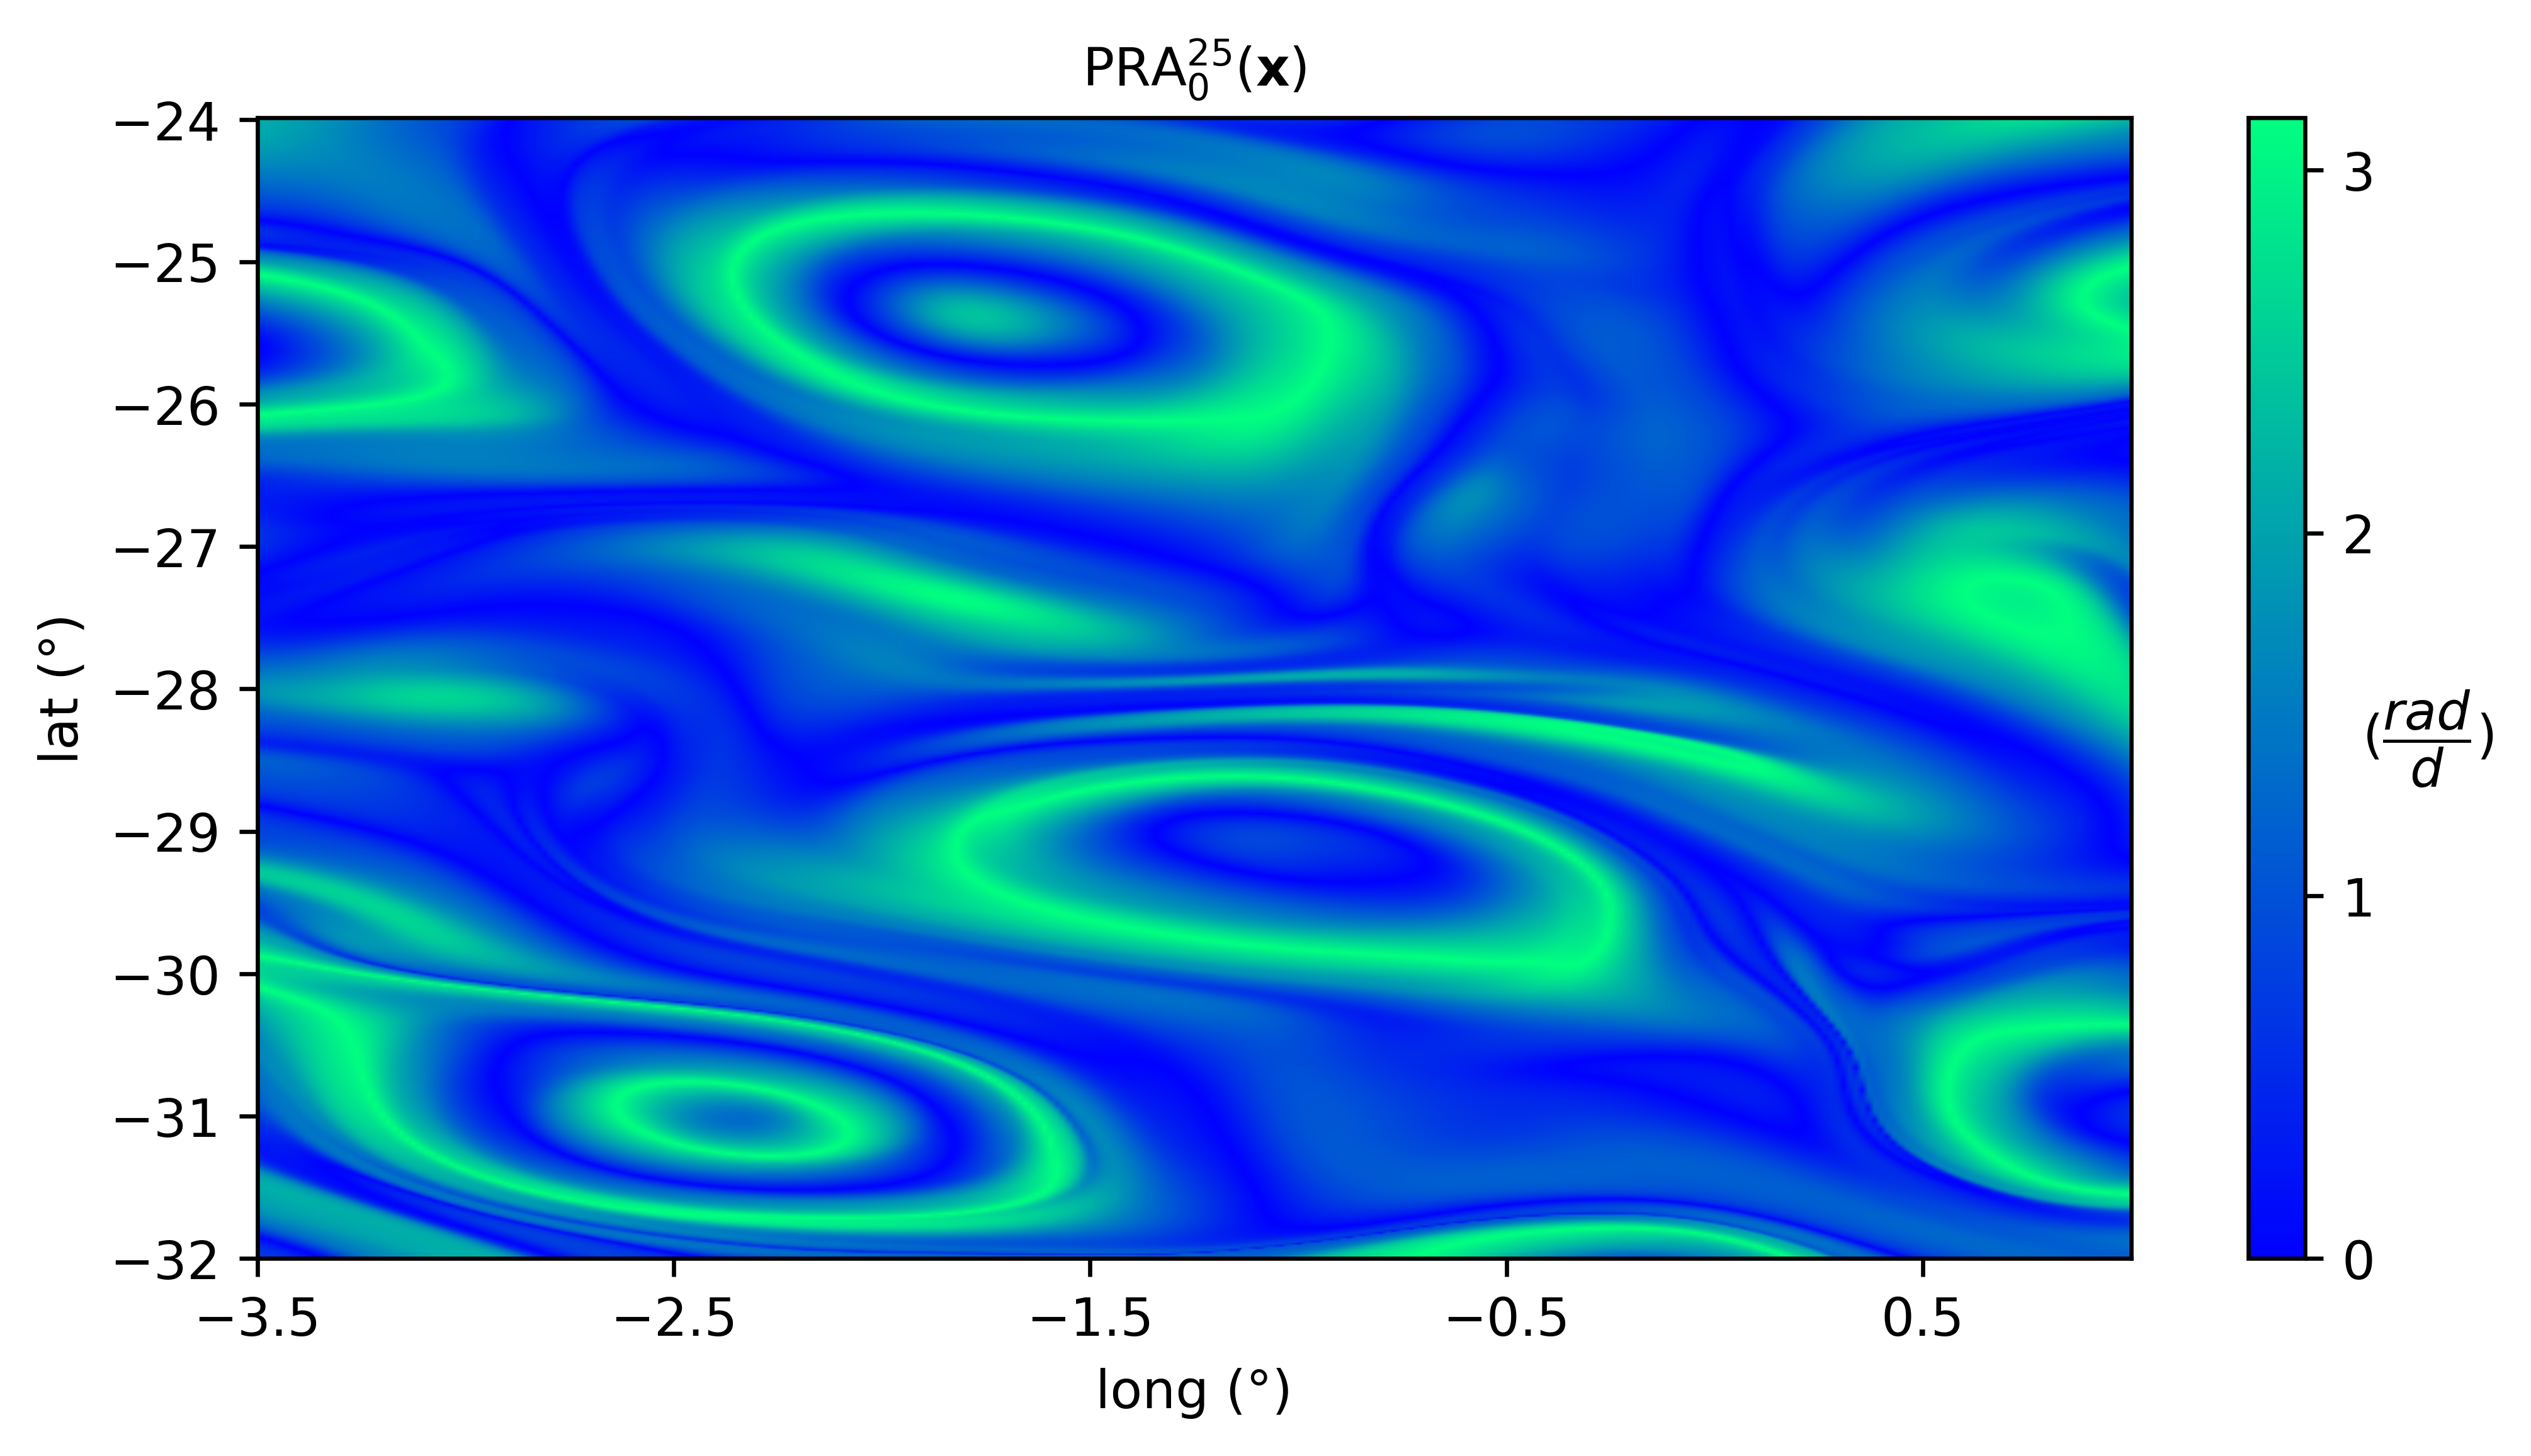

In [7]:
######################## PLOT RESULTS ########################

# Import plotting libraries
import matplotlib.pyplot as plt

# Figure/Axes
fig = plt.figure(figsize=(8, 4), dpi = 600)
ax = plt.axes()

# Contourplot of PRA over meshgrid of initial conditions
cax = ax.contourf(X0_gridded, Y0_gridded, np.ma.masked_invalid(PRA_gridded), cmap = "winter", levels = 600)

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Ticks
ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain), 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain), 1))

# Colorbar
cbar = fig.colorbar(cax, ticks = [0, 1, 2, 3])
cbar.ax.set_ylabel(r'$(\dfrac{rad}{d})$', rotation = 0, labelpad = 10, fontsize = 10)

# Title
ax.set_title(r'$ \mathrm{PRA}$'+f'$_{{{int(time[0])}}}^{{{int(time[-1])}}}$'+r'$(\mathbf{x})$', fontsize = 10)

plt.show()

Elliptic LCS are identified as elliptic islands around local extrema in the PRA field. The elliptic LCSs are visible as concentric closed contours of the PRA at time $ t_0 $. These elliptic islands clearly distinguish vortical regions from the remaining flow. Note that the $ \mathrm{PRA} $ highlights the same vortical flow structures as other commonly used rotation diagnostics such as the [Trajectory Rotation Average](http://localhost:8888/notebooks/TBarrier/2D/demos/AdvectiveBarriers/TRA/Main/TRAAgulhas.ipynb), the [EllipticLCS](http://localhost:8888/notebooks/TBarrier/2D/demos/AdvectiveBarriers/EllipticLCS/Main/EllipticLCSAgulhas.ipynb) or the [LAVD](http://localhost:8888/notebooks/TBarrier/2D/demos/AdvectiveBarriers/LAVD/Main/LAVDAgulhas.ipynb).

# References

[1] Farazmand, M., & Haller, G. (2016). Polar rotation angle identifies elliptic islands in unsteady dynamical systems. Physica D: Nonlinear Phenomena, 315, 1-12.